<a href="https://colab.research.google.com/github/Sparrow0hawk/RAMP-UA/blob/examples-section/examples/colab/ramp-colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sensitivity Analysis with the OpenCL RAMP model

This is an example notebook that runs on Google Colab that makes use of the RAMP-UA OpenCL model.


In [1]:
! add-apt-repository ppa:graphics-drivers/ppa -y
! apt update
! apt install -y nvidia-384 nvidia-384-dev
! apt-get install -y g++ freeglut3-dev build-essential libx11-dev libxmu-dev libxi-dev libglu1-mesa libglu1-mesa-dev

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Get:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release [564 B]
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release.gpg [833 B]
Hit:10 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:11 http://security.ubuntu.com/ubuntu bionic-security/universe amd64 Pac

In [2]:
! apt-get install git-lfs

! git lfs install

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  git-lfs
0 upgraded, 1 newly installed, 0 to remove and 63 not upgraded.
Need to get 2,129 kB of archives.
After this operation, 7,662 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 git-lfs amd64 2.3.4-1 [2,129 kB]
Fetched 2,129 kB in 1s (2,897 kB/s)
Selecting previously unselected package git-lfs.
(Reading database ... 144623 files and directories currently installed.)
Preparing to unpack .../git-lfs_2.3.4-1_amd64.deb ...
Unpacking git-lfs (2.3.4-1) ...
Setting up git-lfs (2.3.4-1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Error: Failed to call git rev-parse --git-dir --show-toplevel: "fatal: not a git repository (or any of the parent directories): .git\n"
Git LFS initialized.


In [3]:
%%bash

git clone --single-branch --branch examples-section https://github.com/Urban-Analytics/RAMP-UA.git
# download the specific notebook functions file
curl -O https://raw.githubusercontent.com/Urban-Analytics/RAMP-UA/master/experiments/functions.py

# download cache file
curl -o default.npz https://zenodo.org/record/4153512/files/default.npz?download=1

Cloning into 'RAMP-UA'...
Filtering content: 100% (17/17), 638.53 MiB | 59.96 MiB/s, done.
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2106  100  2106    0     0  14040      0 --:--:-- --:--:-- --:--:-- 14040
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  162M  100  162M    0     0  13.7M      0  0:00:11  0:00:11 --:--:-- 15.0M


In [4]:
%%bash

export PYTHONPATH=
wget https://repo.continuum.io/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh
chmod +x Miniconda3-4.5.4-Linux-x86_64.sh
bash ./Miniconda3-4.5.4-Linux-x86_64.sh -b -f -p /usr/local

PREFIX=/usr/local
installing: python-3.6.5-hc3d631a_2 ...
installing: ca-certificates-2018.03.07-0 ...
installing: conda-env-2.6.0-h36134e3_1 ...
installing: libgcc-ng-7.2.0-hdf63c60_3 ...
installing: libstdcxx-ng-7.2.0-hdf63c60_3 ...
installing: libffi-3.2.1-hd88cf55_4 ...
installing: ncurses-6.1-hf484d3e_0 ...
installing: openssl-1.0.2o-h20670df_0 ...
installing: tk-8.6.7-hc745277_3 ...
installing: xz-5.2.4-h14c3975_4 ...
installing: yaml-0.1.7-had09818_2 ...
installing: zlib-1.2.11-ha838bed_2 ...
installing: libedit-3.1.20170329-h6b74fdf_2 ...
installing: readline-7.0-ha6073c6_4 ...
installing: sqlite-3.23.1-he433501_0 ...
installing: asn1crypto-0.24.0-py36_0 ...
installing: certifi-2018.4.16-py36_0 ...
installing: chardet-3.0.4-py36h0f667ec_1 ...
installing: idna-2.6-py36h82fb2a8_1 ...
installing: pycosat-0.6.3-py36h0a5515d_0 ...
installing: pycparser-2.18-py36hf9f622e_1 ...
installing: pysocks-1.6.8-py36_0 ...
installing: ruamel_yaml-0.15.37-py36h14c3975_2 ...
installing: six-1.11

--2020-10-29 13:21:59--  https://repo.continuum.io/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.201.79, 104.18.200.79, 2606:4700::6812:c94f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.201.79|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://repo.anaconda.com/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh [following]
--2020-10-29 13:21:59--  https://repo.anaconda.com/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58468498 (56M) [application/x-sh]
Saving to: ‘Miniconda3-4.5.4-Linux-x86_64.sh’

     0K .......... .......... .......... .......... ..........  0% 74.1M 1s
    50K .......... .......... .......... .......... ..........  0%

In [5]:
%%bash 

!apt install libspatialindex-dev

echo "python 3.6.*" > /usr/local/conda-meta/pinned

#Installing another conda package first something first seems to fix https://github.com/rapidsai/rapidsai-csp-utils/issues/4
conda install --channel defaults conda python=3.6 --yes
conda update -y -c conda-forge -c defaults --all
conda install -y --prefix /usr/local -c conda-forge -c defaults openssl six

conda install -y --prefix /usr/local \
        -c conda-forge -c defaults \
        python=3.6 pandas=1.0.3 matplotlib=3.1.3 pyopencl=2020.2.2 \
        click pyyaml rpy2=3.3.2 numpy=1.18.5 tqdm scipy=1.5.2 \
        swifter=0.304 tzlocal r-mixdist r-tidyr=1.1.0 r-stringr \
        r-readr r-curl imageio=2.8.0 r-janitor=2.0.1 r-stringi=1.4.6 r-devtools=2.3.1 \
        r-data.table r-mixdist r-mgcv r-RecordLinkage r-tidyselect r-rvcheck r-stringdist pocl \
        geopandas=0.7.0 descartes

pip install -r RAMP-UA/microsim/opencl/requirements.txt
pip install convertbng

Solving environment: ...working... done

## Package Plan ##

  environment location: /usr/local

  added / updated specs: 
    - conda
    - python=3.6


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    urllib3-1.25.11            |             py_0          93 KB
    libedit-3.1.20191231       |       h14c3975_1         121 KB
    ruamel_yaml-0.15.87        |   py36h7b6447c_1         256 KB
    sqlite-3.33.0              |       h62c20be_0         2.0 MB
    conda-package-handling-1.7.2|   py36h03888b9_0         967 KB
    wheel-0.35.1               |             py_0          36 KB
    setuptools-50.3.0          |   py36hb0f4dca_1         891 KB
    cffi-1.14.3                |   py36he30daa8_0         224 KB
    readline-8.0               |       h7b6447c_0         428 KB
    requests-2.24.0            |             py_0          54 KB
    xz-5.2.5                   |       h7b6447c_0  

bash: line 2: !apt: command not found
urllib3-1.25.11      |   93 KB | ########## | 100% 
libedit-3.1.20191231 |  121 KB | ########## | 100% 
ruamel_yaml-0.15.87  |  256 KB | ########## | 100% 
sqlite-3.33.0        |  2.0 MB | ########## | 100% 
conda-package-handli |  967 KB | ########## | 100% 
wheel-0.35.1         |   36 KB | ########## | 100% 
setuptools-50.3.0    |  891 KB | ########## | 100% 
cffi-1.14.3          |  224 KB | ########## | 100% 
readline-8.0         |  428 KB | ########## | 100% 
requests-2.24.0      |   54 KB | ########## | 100% 
xz-5.2.5             |  438 KB | ########## | 100% 
conda-4.9.1          |  3.1 MB | ########## | 100% 
idna-2.10            |   56 KB | ########## | 100% 
cryptography-3.1.1   |  612 KB | ########## | 100% 
_libgcc_mutex-0.1    |    3 KB | ########## | 100% 
six-1.15.0           |   13 KB | ########## | 100% 
ncurses-6.2          |  1.1 MB | ########## | 100% 
chardet-3.0.4        |  197 KB | ########## | 100% 
openssl-1.1.1h       |  3.

In [6]:
%%bash

cd RAMP-UA/

pip install .

Processing /content/RAMP-UA
  Created wheel for RAMP-UA: filename=RAMP_UA-1.1.0.dev0-py3-none-any.whl size=119467 sha256=2130b37786ad893dcb0e296fefed5ddc2cb85f1e27ad595a083e964996bec187
  Stored in directory: /root/.cache/pip/wheels/0f/92/73/6911b3fe3e252b26e55d4276ca36887f11f749fe11aeee325f
Successfully built RAMP-UA


In [7]:
import sys

sys.path.append("/usr/local/lib/python3.6/site-packages")
#sys.path.append("/content/RAMP-UA")
sys.path

['',
 '/env/python',
 '/usr/lib/python36.zip',
 '/usr/lib/python3.6',
 '/usr/lib/python3.6/lib-dynload',
 '/usr/local/lib/python3.6/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.6/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/usr/local/lib/python3.6/site-packages']

In [8]:
!python --version

Python 3.6.11


In [9]:
import microsim

In [10]:
import pyopencl

### Import opencl modules

In [11]:
import multiprocessing as mp
import numpy as np
#import multiprocess as mp  # A fork of multiprocessing that uses dill rather than pickle
import yaml # pyyaml library for reading the parameters.yml file
import os

import matplotlib.pyplot as plt

from microsim.opencl.ramp.run import run_headless
from microsim.opencl.ramp.snapshot_convertor import SnapshotConvertor
from microsim.opencl.ramp.snapshot import Snapshot
from microsim.opencl.ramp.params import Params, IndividualHazardMultipliers, LocationHazardMultipliers
from microsim.opencl.ramp.simulator import Simulator
from microsim.opencl.ramp.disease_statuses import DiseaseStatus

import functions # Some additional notebook-specific functions required (functions.py)

# Useful for connecting to this kernel
%connect_info

{
  "shell_port": 44993,
  "iopub_port": 40127,
  "stdin_port": 48893,
  "control_port": 35801,
  "hb_port": 34423,
  "ip": "127.0.0.1",
  "key": "",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-802f1f6c-14e4-4826-b3b9-465ccf83537d.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


### Setup params for all runs

Read the parameters file

In [13]:
PARAMETERS_FILENAME = "default.yml"
with open(os.path.join("RAMP-UA","model_parameters", PARAMETERS_FILENAME)) as f:
    parameters = yaml.load(f, Loader=yaml.SafeLoader)
    
sim_params = parameters["microsim"]  # Parameters for the dynamic microsim (python)
calibration_params = parameters["microsim_calibration"]
disease_params = parameters["disease"]  # Parameters for the disease model (r)

Prepare the parameters for the OpenCL model. (See [main.py](https://github.com/Urban-Analytics/RAMP-UA/blob/052861cc51be5bc1827c85bb827209f0df73c685/microsim/main.py#L262) for an example of how this is done in the code). 

In [14]:
current_risk_beta = disease_params['current_risk_beta']

# The OpenCL model incorporates the current risk beta by pre-multiplying the hazard multipliers with it
location_hazard_multipliers = LocationHazardMultipliers(
    retail=calibration_params["hazard_location_multipliers"]["Retail"] * current_risk_beta,
    primary_school=calibration_params["hazard_location_multipliers"]["PrimarySchool"] * current_risk_beta,
    secondary_school=calibration_params["hazard_location_multipliers"]["SecondarySchool"] * current_risk_beta,
    home=calibration_params["hazard_location_multipliers"]["Home"] * current_risk_beta,
    work=calibration_params["hazard_location_multipliers"]["Work"] * current_risk_beta,
)

# Individual hazard multipliers can be passed straight through
individual_hazard_multipliers = IndividualHazardMultipliers(
    presymptomatic=calibration_params["hazard_individual_multipliers"]["presymptomatic"],
    asymptomatic=calibration_params["hazard_individual_multipliers"]["asymptomatic"],
    symptomatic=calibration_params["hazard_individual_multipliers"]["symptomatic"]
)

proportion_asymptomatic = disease_params["asymp_rate"]

params = Params(
    location_hazard_multipliers=location_hazard_multipliers,
    individual_hazard_multipliers=individual_hazard_multipliers,
    proportion_asymptomatic=proportion_asymptomatic
)

### Get snapshot path
**NB** this is the path to the OpenCL snapshot file generated by running `microsim/main.py`. To run with new population data just re-run `main.py --opencl` without the `--use-cache` option, so that it regenerates a new snapshot file and writes it to this location.

In [18]:
opencl_dir = "RAMP-UA/microsim/opencl"
snapshot_filepath = "/content/default.npz"

In [19]:
import pyopencl 

platforms = pyopencl.get_platforms()

for i, platform in enumerate(platforms):
    devices = platform.get_devices()
    
    print(devices)


[<pyopencl.Device 'pthread-Intel(R) Xeon(R) CPU @ 2.20GHz' on 'Portable Computing Language' at 0x461e340>]


## Run OpenCL simulation for multiple repetitions

In [21]:
iterations = 120
repetitions = 10
num_seed_days = 10
use_gpu=False

summaries = []
final_results = []
# Prepare the function arguments as lists for starmap
l_i = [i for i in range(repetitions)]
l_iterations = [iterations] * repetitions
l_snapshot_filepath = [snapshot_filepath] * repetitions
l_params = [params] * repetitions
l_opencl_dir = [opencl_dir] * repetitions
l_num_seed_days = [num_seed_days] * repetitions
l_use_gpu = [use_gpu] * repetitions

#results = functions.run_opencl_model_multiprocess(
#    l_i, l_iterations, l_snapshot_filepath, l_params, l_opencl_dir, l_num_seed_days, l_use_gpu)

import itertools  # (only while I can't get multiprocessing to work)
try:
    with mp.Pool(processes=int(os.cpu_count())) as pool:
        #results = pool.starmap(
        results = itertools.starmap(
            functions._run_opencl_model, zip(
                l_i, l_iterations, l_snapshot_filepath, l_params, l_opencl_dir, l_num_seed_days, l_use_gpu
        ))
finally:  # Make sure they get closed (shouldn't be necessary)
    pool.close()

summaries = [x[0] for x in results]
final_results = [x[1] for x in results]

# Conver the summaries 

Running simulation 1.


Running simulation: 100%|██████████| 120/120 [00:18<00:00,  6.64it/s]


Running simulation 2.


Running simulation: 100%|██████████| 120/120 [00:18<00:00,  6.48it/s]


Running simulation 3.


Running simulation: 100%|██████████| 120/120 [00:17<00:00,  6.71it/s]


Running simulation 4.


Running simulation: 100%|██████████| 120/120 [00:17<00:00,  6.77it/s]


Running simulation 5.


Running simulation: 100%|██████████| 120/120 [00:17<00:00,  6.68it/s]


Running simulation 6.


Running simulation: 100%|██████████| 120/120 [00:18<00:00,  6.63it/s]


Running simulation 7.


Running simulation: 100%|██████████| 120/120 [00:17<00:00,  6.87it/s]


Running simulation 8.


Running simulation: 100%|██████████| 120/120 [00:17<00:00,  6.75it/s]


Running simulation 9.


Running simulation: 100%|██████████| 120/120 [00:18<00:00,  6.67it/s]


Running simulation 10.


Running simulation: 100%|██████████| 120/120 [00:17<00:00,  6.87it/s]


## Plot output summary data

### Total counts of disease status

In [ ]:
def plot_summaries(summaries, plot_type="error_bars"):

    #fig, ax = plt.subplots(1, len(DiseaseStatus), sharey=True)
    fig, ax = plt.subplots(1, 1, figsize=(10,7))
    
    # Work out the number of repetitions and iterations
    iters, reps = _get_iters_and_reps(summaries)
    x = range(iters)

    for d, disease_status in enumerate(DiseaseStatus):
        if disease_status==DiseaseStatus.Susceptible or disease_status==DiseaseStatus.Recovered:
            continue
        # Calculate the mean and standard deviation
        matrix = np.zeros(shape=(reps,iters))
        for rep in range(reps):
            matrix[rep] = summaries[rep].total_counts[d]
        mean = np.mean(matrix, axis=0)
        sd = np.std(matrix, axis=0)
        if plot_type == "error_bars":
            ax.errorbar(x, mean, sd, label=f"{disease_status}" )
        elif plot_type == "lines":
            for rep in range(reps):
                ax.plot(x, matrix[rep], label=f"{disease_status} {rep}", 
                        color=plt.cm.get_cmap("hsv", len(DiseaseStatus))(d) )
                
    ax.legend() 
    ax.set_title("Disease Status")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Number of cases")

def _get_iters_and_reps(summaries):
    reps = len(summaries)
    iters = len(summaries[0].total_counts[0])
    return (iters, reps)

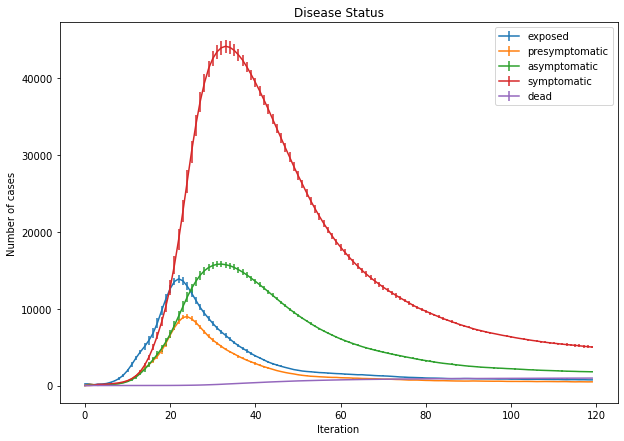

In [ ]:
plot_summaries(summaries=summaries, plot_type="error_bars")

In [ ]:
#plot_summaries(summaries=summaries, plot_type="lines")

### Disease statuses by age

In [ ]:
   
def plot_disease_status_by_age(summaries):

    #fig, ax = plt.subplots(1, len(DiseaseStatus), sharey=True)
    fig, ax = plt.subplots(int(len(DiseaseStatus)/2), int(len(DiseaseStatus)/2), 
                           figsize=(15,11), tight_layout=True)
    iters, reps = _get_iters_and_reps(summaries)
    x = range(iters)
    age_thresholds = summaries[0].age_thresholds

    for d, disease_status in enumerate(DiseaseStatus):
        lower_age_bound = 0
        for age_idx in range(len(age_thresholds)):
            matrix = np.zeros(shape=(reps, iters))
            for rep in range(reps):
                #matrix[age_idx][rep][it] = summaries[rep].age_counts[str(disease_status)][age_idx][it]
                matrix[rep] = summaries[rep].age_counts[str(disease_status)][age_idx]
            mean = np.mean(matrix, axis=0)
            sd = np.std(matrix, axis=0)
            ax.flat[d].errorbar(x, mean, sd, label=f"{lower_age_bound} - {age_thresholds[age_idx]}" )
            lower_age_bound = age_thresholds[age_idx]
                
            ax.flat[d].legend() 
            ax.flat[d].set_title(f"{str(disease_status)}")
            ax.flat[d].set_xlabel("Iteration")
            ax.flat[d].set_ylabel("Number of cases")
    #fig.set_title(f"Num {disease_status} people by age group")

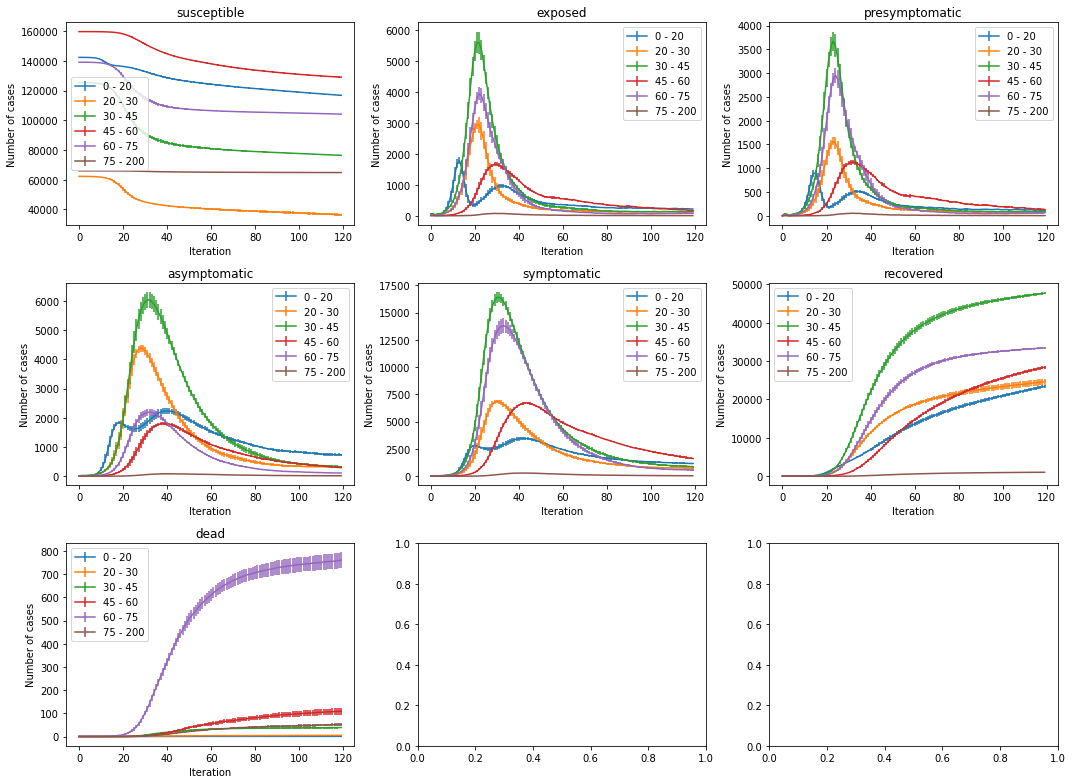

In [ ]:
plot_disease_status_by_age(summaries)

### Plot MSOA geodata

#### Load MSOA shapes

Loading OSM buildings shapefile
Loaded 206583 buildings from shapefile
Loaded 7201 MSOA shapes with projection epsg:27700
Loaded 107 devon MSOA codes
Filtered 107 devon MSOA shapes


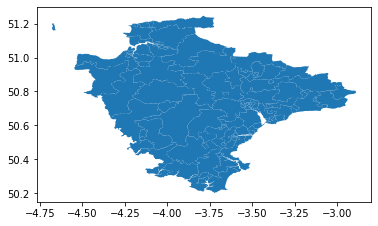

In [ ]:
from microsim.load_msoa_locations import load_osm_shapefile, load_msoa_shapes
import pandas as pd

data_dir = ("RAMP-UA/devon_data")

osm_buildings = load_osm_shapefile(data_dir)

devon_msoa_shapes = load_msoa_shapes(data_dir, visualize=False)

devon_msoa_shapes.plot()
plt.show()

In [ ]:
import pandas as pd

def plot_msoa_choropleth(msoa_shapes, summary, disease_status, timestep):
    # get dataframes for all statuses
    msoa_data = summary.get_area_dataframes()
    
    msoa_data_for_status = msoa_data[disease_status]

    # add "Code" column so dataframes can be merged
    msoa_data_for_status["Code"] = msoa_data_for_status.index
    msoa_shapes = pd.merge(msoa_shapes, msoa_data_for_status, on="Code")

    msoa_shapes.plot(column=f"Day{timestep}", legend=True)
    plt.show()

### Plot disease status by MSOA for a given timestep and status

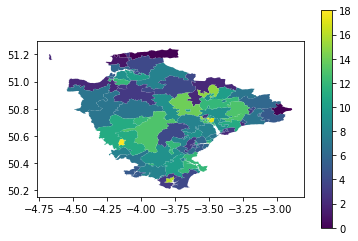

In [ ]:
disease_status = "exposed"

plot_msoa_choropleth(devon_msoa_shapes, summaries[0], disease_status, 99)